### Gesture Index Mapping

| Index | Gesture | Description                        |
|-------|---------|------------------------------------|
| 0     | LP      | Lateral prehension                 |
| 1     | TA      | Thumb adduction                    |
| 2     | TLFO    | Thumb and little finger opposition |
| 3     | TIFO    | Thumb and index finger opposition  |
| 4     | TLFE    | Thumb and little finger extension  |
| 5     | TIFE    | Thumb and index finger extension   |
| 6     | IMFE    | Index and middle finger extension  |
| 7     | LFE     | Little finger extension            |
| 8     | IFE     | Index finger extension             |
| 9     | TE      | Thumb extension                    |
| 10    | WF      | Wrist flexion                      |
| 11    | WE      | Wrist extension                    |
| 12    | FP      | Forearm pronation                  |
| 13    | FS      | Forearm supination                 |
| 14    | HO      | Hand open                          |
| 15    | HC      | Hand close                         |
| 16    | REST    | Rest / No movement                 |
- The order of the 16 gestures was randomized and a resting (REST) trial was collected after all 16 gestures were performed once. 
- A ten-seconds relaxing period was provided between each trial. 

## 2.1 - Basic structure comfirmation
- verify sampling rate for Nyquist limit (assume T = 5sec and f_s = N/T (N = # of samples, T = period))
- create a channel inventory (Forearm_1–16, Wrist_1–12)
- check for signal amplitude
    - Amplitude sanity: robust P5–P95, MAD, RMS.
    - Clipping/saturation: % samples near edge, flat runs.
- Welch PSD: main energy 20–450 Hz.
- Powerline: check 50/60 Hz residuals (and harmonics).
- Usable band fraction: ≥70% of power in 20–450 Hz.
- Summaries & visuals
    - RMS & envelope: 2–3 representative channels, per trial.
    - Consistency check: RMS variation across trials of same gesture.
    - Plots:
        - Mosaic raw traces (all 28 channels).
        - PSD (one forearm + one wrist).
        - Envelope overlay.
        - Heatmap of RMS (channels × trials).
- Acceptance gates
    - Hard fail: wrong fs/duration, NaN/Inf, clipping >0.1%, missing channels.
    - Soft flag: low band power (<70%), poor notch, high trial variability.



<details>
<summary>Raw notes (click to expand)</summary>

check for amplitude, duration, sampling rate
    - amplitude: make sure that there r no clipping or SATURATION
    - infer duration from checking the graph on whether there r values after 5sec
    - validate sampling rate 
- whether the powerline noise still exist after the 60Hz notch filter
- Dshow that dataset shape is: 7 trials × 17 gestures
- show all 28 channels (16 forearm + 12 wrist) in a single trial -> # use n_channel = 30 to see examine abnormal

> things unsure to put in or not

- mean EMG activity?
- PSD?
- EMG Envolope? 
- RMS?

3) Robust amplitude band: P5–P95 and MAD -> this could replace the min/max which is outlier sensitive 
Why:
Raw min/max are fragile: one spike can blow them up. A robust spread (percentiles + MAD) tells you where most of the signal lives, resisting outliers.
What:
P5 and P95: the central 90% amplitude band.
MAD (median absolute deviation): robust noise/variability proxy.
How:
Compute P5, P95, MAD on raw volts (or µV/mV—use header units).
Sanity for sEMG: typical resting RMS tens of µV; active contractions often a few hundred µV RMS; peak-to-peak below ~10 mV for surface EMG in most setups. If P95 is “volts”, your scale is wrong.
Standard?
Robust stats are common in EMG QA and general biosignal QC to avoid spike bias.

7) Usable band power fraction (20–450 Hz)
Why:
sEMG lives predominantly in ~20–450 Hz. If most power is below 20 Hz, you’re seeing motion/sweat artefacts; if it’s above 450–500 Hz, you’ve got high-frequency noise (EMI, digital).
What:
Fraction of total power that sits inside the EMG band.
How:
Use the same Welch PSD as above.
Compute P_band = ∫_{20}^{450} PSD(f) df.
Compute P_total = ∫_{0}^{fs/2} PSD(f) df (or 1–900 Hz if you want to ignore DC).
Fraction F = P_band / P_total. Flag if F < 0.70 (70%).
Standard?
Band-limited power fractions (or spectral moments) are common in EMG QA and are a simple, interpretable summary.

<details>


Found 129 .mat files
Selected file: session3_participant41.mat
Visualizing Gesture: IMFE (Trial 4)
Forearm Sampling Rate: 2048.0 Hz | Wrist Sampling Rate: 2048.0 Hz


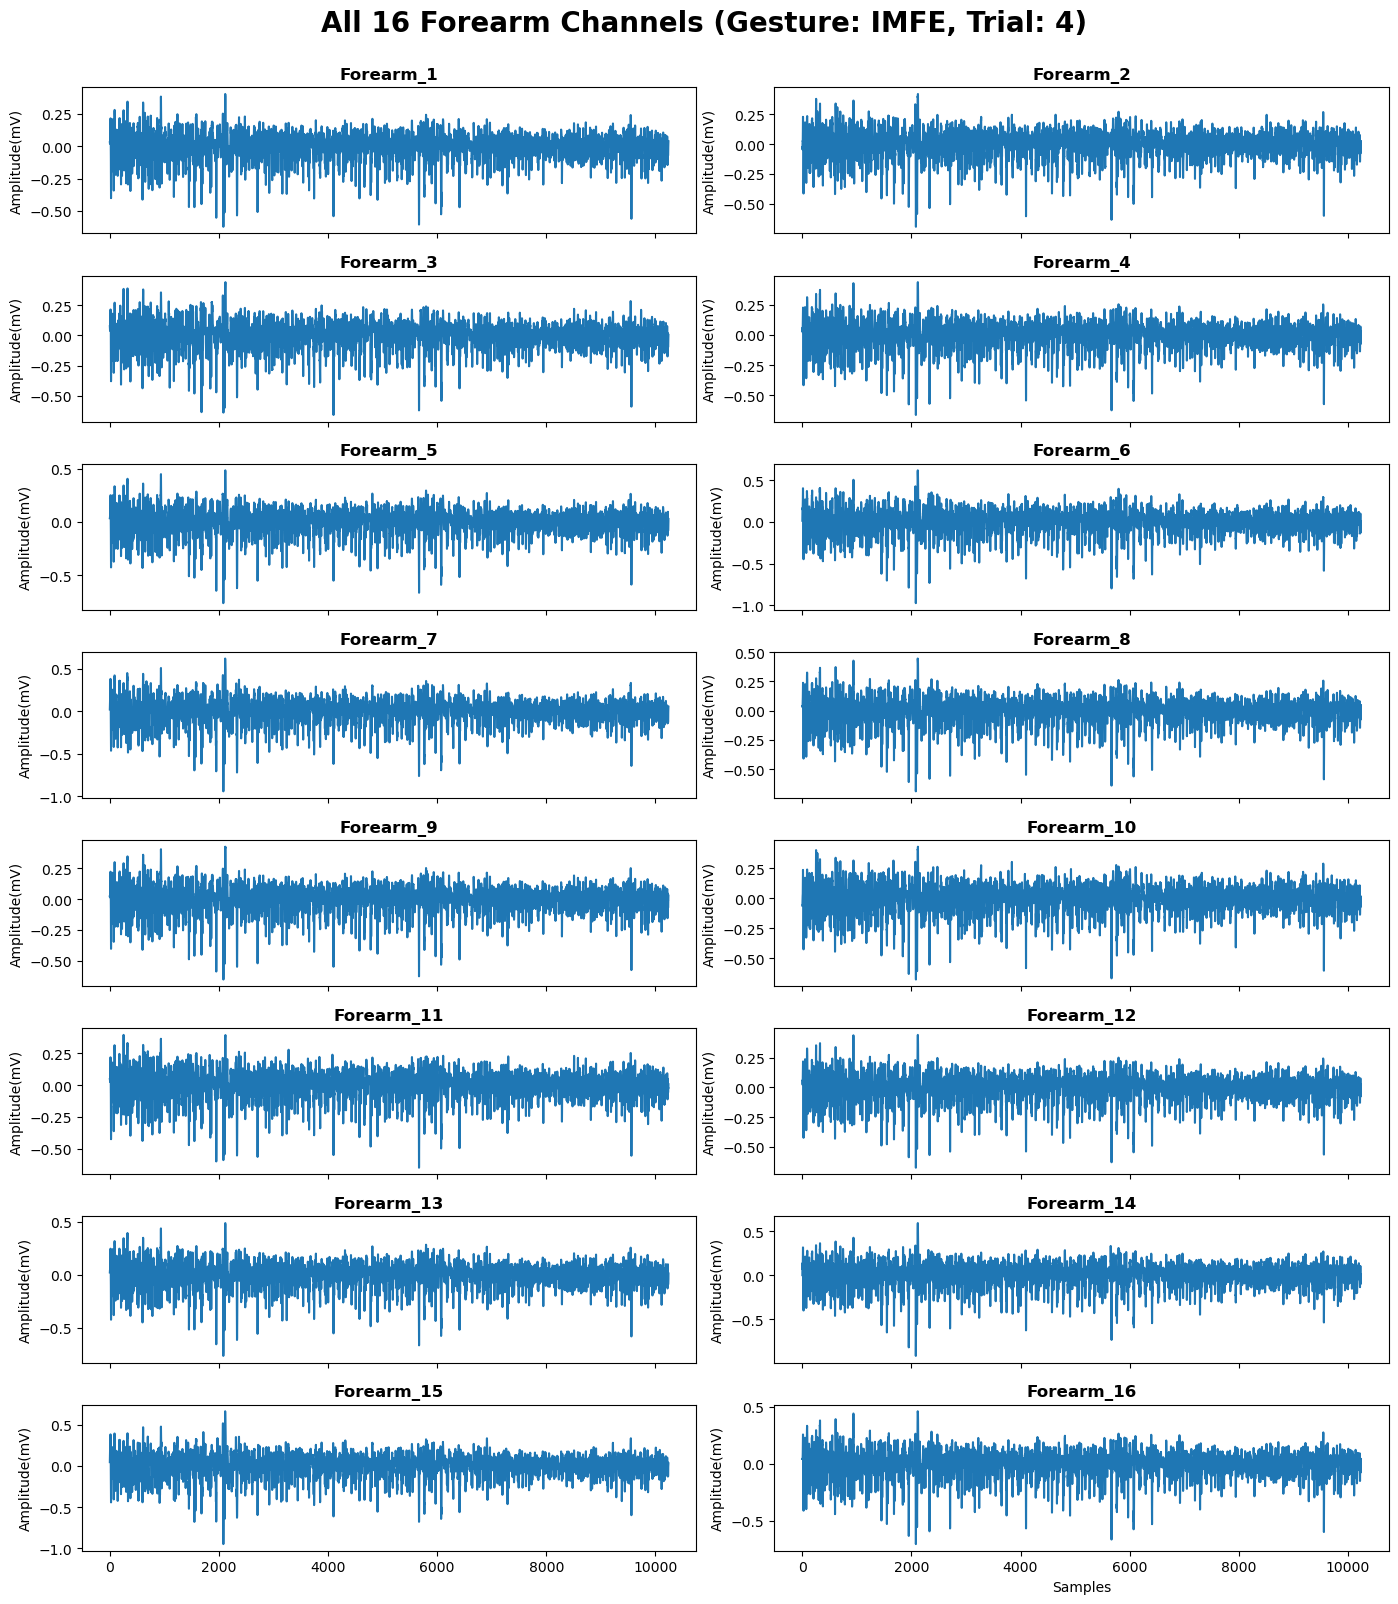

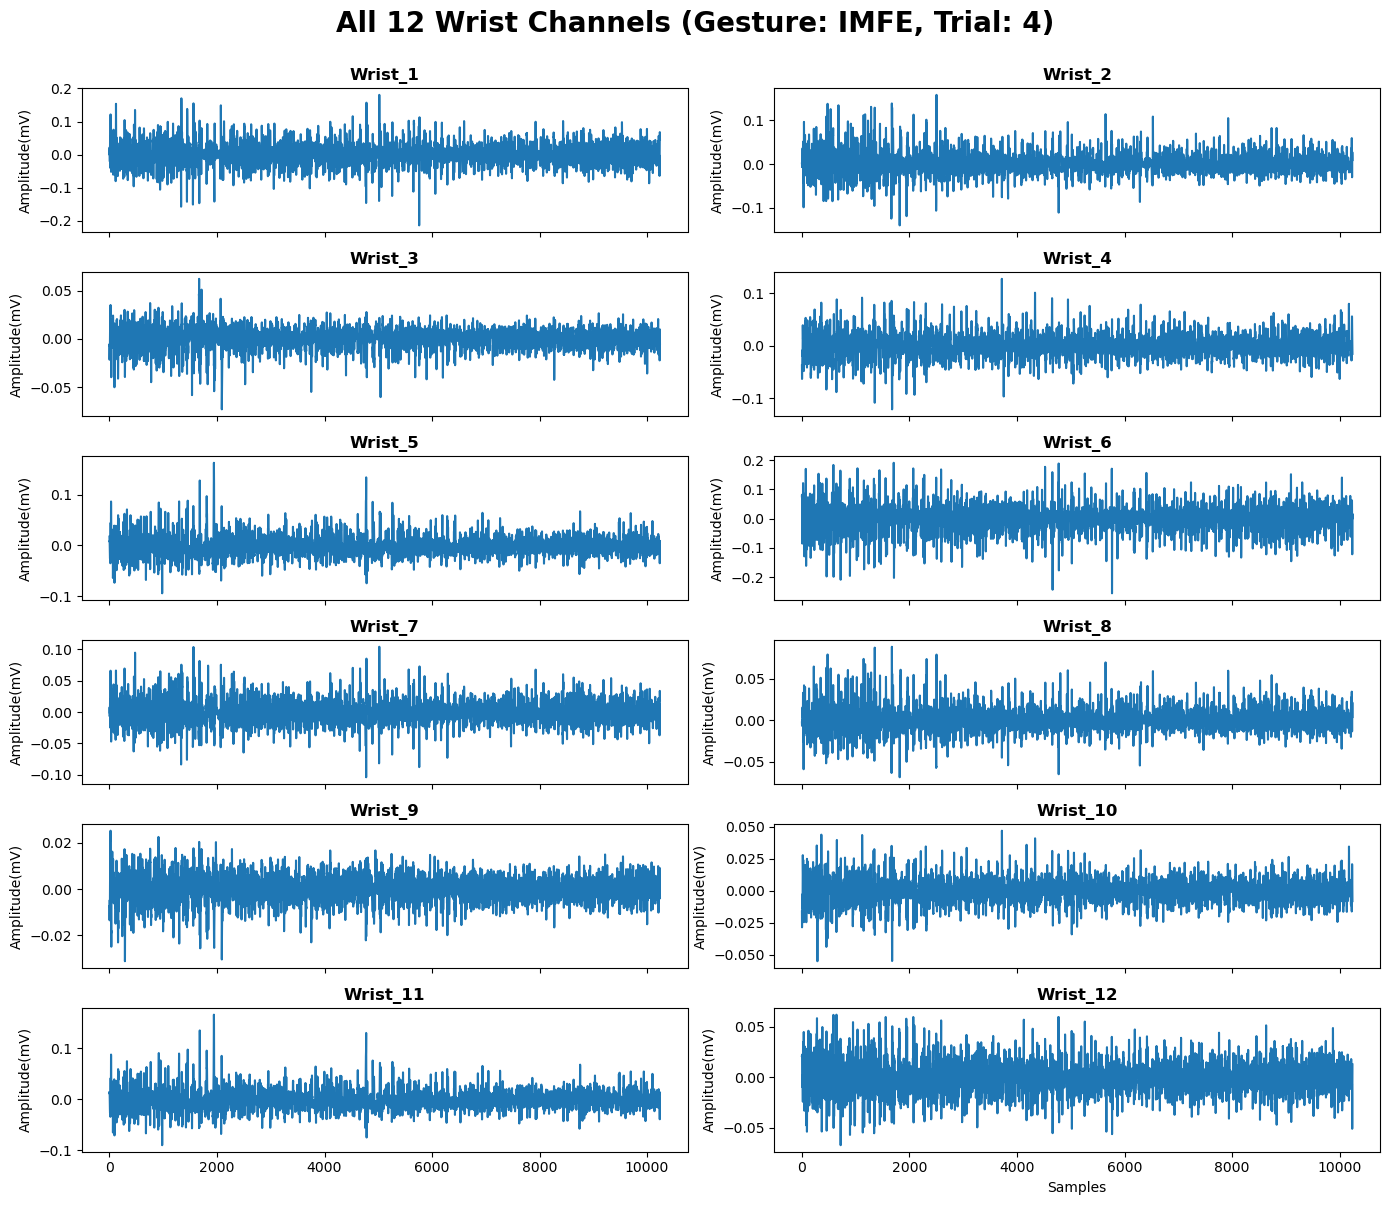

In [3]:
import numpy as np
import scipy.io as sio
from pathlib import Path
import matplotlib.pyplot as plt
import random
from natsort import natsorted


# Set all EMG folders here
folders = [
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted",
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session2_converted",
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session3_converted"
 ]

# Collect all .mat files
mat_files = []
for folder in folders:
    mat_files.extend(natsorted(list(Path(folder).glob("*.mat"))))

print(f"\nFound {len(mat_files)} .mat files")

# Define gesture labels
gesture_labels = [
    "LP", "TA", "TLFO", "TIFO", "TLFE", "TIFE", "IMFE", "LFE",
    "IFE", "TE", "WF", "WE", "FP", "FS", "HO", "HC", "REST"
]

# Choose what file to load:
sample_file = random.choice(mat_files)                                              # Option 1: Random file
# sample_file = mat_files[0]                                                        # Option 2: By file index
# sample_file = [f for f in mat_files if "session1_participant1.mat" in str(f)]     # Option 3: By name

print(f"Selected file: {sample_file.name}")
data = sio.loadmat(sample_file)

# Total number of trials and gestures
num_trials = 7
num_gestures = 17

# Option to choose random or specific indices
use_random = True  # Set to False to assign specific indices
if use_random: #randomly select a trial and gesture
    trial_idx = random.randint(0, num_trials - 1)
    gesture_idx = random.randint(0, num_gestures - 1)
else:
    trial_idx = 0  # Example: First trial
    gesture_idx = 16  # Example: 17th gesture (REST)
    # Ensure indices are within valid range
    assert 0 <= trial_idx < num_trials, f"trial_idx must be between 0 and {num_trials - 1}"
    assert 0 <= gesture_idx < num_gestures, f"gesture_idx must be between 0 and {num_gestures - 1}"   

# Load forearm and wrist data for the selected trial and gesture
forearm = data['DATA_FOREARM'][trial_idx, gesture_idx]
wrist = data['DATA_WRIST'][trial_idx, gesture_idx]
channels = [f'Forearm_{i+1}' for i in range(16)] + [f'Wrist_{i+1}' for i in range(12)]

# Get the gesture name
gesture_name = gesture_labels[gesture_idx]
print(f"Visualizing Gesture: {gesture_name} (Trial {trial_idx + 1})")

# Generalized function to calculate sampling rate and time axis
def calculate_fs_and_time(data, T):
    N = data.shape[0]  # Number of samples
    fs = N / T  # Sampling rate
    time = np.linspace(0, T, N)  # Time axis
    return fs, time

# Duration of the recording
T = 5  # Duration in seconds

# Calculate sampling rate and time axis for forearm
fs_forearm, time_forearm = calculate_fs_and_time(forearm, T)

# Calculate sampling rate and time axis for wrist
fs_wrist, time_wrist = calculate_fs_and_time(wrist, T)
print(f"Forearm Sampling Rate: {fs_forearm} Hz | Wrist Sampling Rate: {fs_wrist} Hz")

# Plot all 16 forearm channels in subplots
fig, axes = plt.subplots(8, 2, figsize=(14, 16), sharex=True)
axes = axes.flatten()
for i in range(16):
    axes[i].plot(forearm[:, i])
    axes[i].set_title(channels[i], fontweight='bold')
    axes[i].set_ylabel('Amplitude(mV)')
axes[-1].set_xlabel('Samples')
plt.suptitle(f'All 16 Forearm Channels (Gesture: {gesture_name}, Trial: {trial_idx + 1})', y=1, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot all 12 wrist channels in subplots
fig, axes = plt.subplots(6, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()
for i in range(12):
    axes[i].plot(wrist[:, i])
    axes[i].set_title(channels[i + 16], fontweight='bold')
    axes[i].set_ylabel('Amplitude(mV)')
axes[-1].set_xlabel('Samples')
plt.suptitle(f'All 12 Wrist Channels (Gesture: {gesture_name}, Trial: {trial_idx + 1})', y=1, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()




In [4]:
from scipy.stats import median_abs_deviation
import pandas as pd

print(f"Selected file: {sample_file.name}")
gesture_name = gesture_labels[gesture_idx]
print(f"Visualizing Gesture: {gesture_name} (gesture {gesture_idx}) - Trial {trial_idx + 1}")   # Get the gesture name

# Function to calculate P5-P95, MAD, and RMS
def calculate_signal_metrics(data):
    p5 = float(np.percentile(data, 5))
    p95 = float(np.percentile(data, 95))
    mad = float(median_abs_deviation(data))
    rms = float(np.sqrt(np.mean(data**2)))
    return {'P5': p5, 'P95': p95, 'MAD': mad, 'RMS': rms}

# Calculate and display metrics for forearm channels
forearm_metrics = [calculate_signal_metrics(forearm[:, ch]) for ch in range(forearm.shape[1])]
forearm_df = pd.DataFrame(forearm_metrics)
forearm_df.index = [f"Forearm_{i+1}" for i in range(forearm.shape[1])]
display(forearm_df.style.format("{:.3f}").background_gradient(cmap="Greens"))

# Calculate and display metrics for wrist channels
wrist_metrics = [calculate_signal_metrics(wrist[:, ch]) for ch in range(wrist.shape[1])]
wrist_df = pd.DataFrame(wrist_metrics)
wrist_df.index = [f"Wrist_{i+1}" for i in range(wrist.shape[1])]
display(wrist_df.style.format("{:.3f}").background_gradient(cmap="Blues"))



Selected file: session3_participant41.mat
Visualizing Gesture: IMFE (gesture 6) - Trial 4


,P5,P95,MAD,RMS
Forearm_1,-0.189,0.147,0.059,0.106
Forearm_2,-0.196,0.161,0.063,0.111
Forearm_3,-0.204,0.170,0.066,0.116
Forearm_4,-0.200,0.156,0.062,0.111
Forearm_5,-0.214,0.167,0.067,0.119
Forearm_6,-0.254,0.210,0.083,0.146
Forearm_7,-0.260,0.205,0.082,0.146
Forearm_8,-0.200,0.158,0.063,0.113
Forearm_9,-0.193,0.149,0.061,0.108
Forearm_10,-0.200,0.165,0.066,0.114


,P5,P95,MAD,RMS
Wrist_1,-0.049,0.048,0.016,0.030
Wrist_2,-0.034,0.039,0.012,0.023
Wrist_3,-0.017,0.016,0.006,0.010
Wrist_4,-0.033,0.035,0.012,0.021
Wrist_5,-0.030,0.033,0.011,0.020
Wrist_6,-0.065,0.062,0.018,0.039
Wrist_7,-0.027,0.028,0.009,0.017
Wrist_8,-0.020,0.022,0.007,0.014
Wrist_9,-0.009,0.008,0.003,0.005
Wrist_10,-0.014,0.014,0.005,0.009


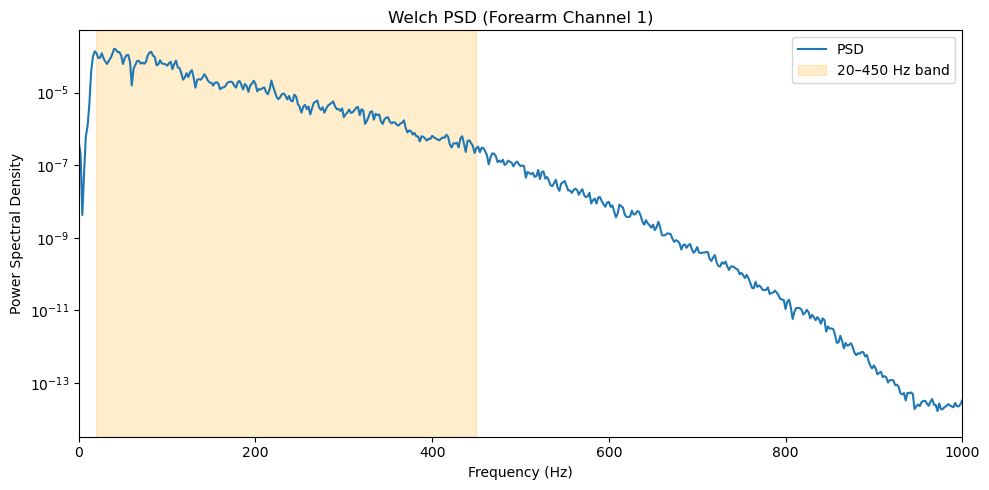

Fraction of power in 20–450 Hz band: 0.94


In [ ]:
# Welch PSD: main energy 20–450 Hz
from scipy.signal import welch

# Choose a representative forearm channel (e.g., channel 1)
channel_idx = 0
signal = forearm[:, channel_idx]

# Use calculated sampling rate
fs = fs_forearm

# Compute Welch PSD
f, Pxx = welch(signal, fs=fs, nperseg=1024, noverlap=512)

# Plot PSD and highlight 20–450 Hz band
plt.figure(figsize=(10, 5))
plt.semilogy(f, Pxx, label='PSD')
plt.axvspan(20, 450, color='orange', alpha=0.2, label='20–450 Hz band')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'Welch PSD (Forearm Channel {channel_idx+1})')
plt.legend()
plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

# Calculate fraction of power in 20–450 Hz band
band_mask = (f >= 20) & (f <= 450)
P_band = np.trapezoid(Pxx[band_mask], f[band_mask])
P_total = np.trapezoid(Pxx, f)
fraction = P_band / P_total if P_total > 0 else 0
print(f"Fraction of power in 20–450 Hz band: {fraction:.2f}")

## 2.2 - diff gesture comparison 
> Show that different gestures produce distinguishable muscle activity (same participants diff channel)

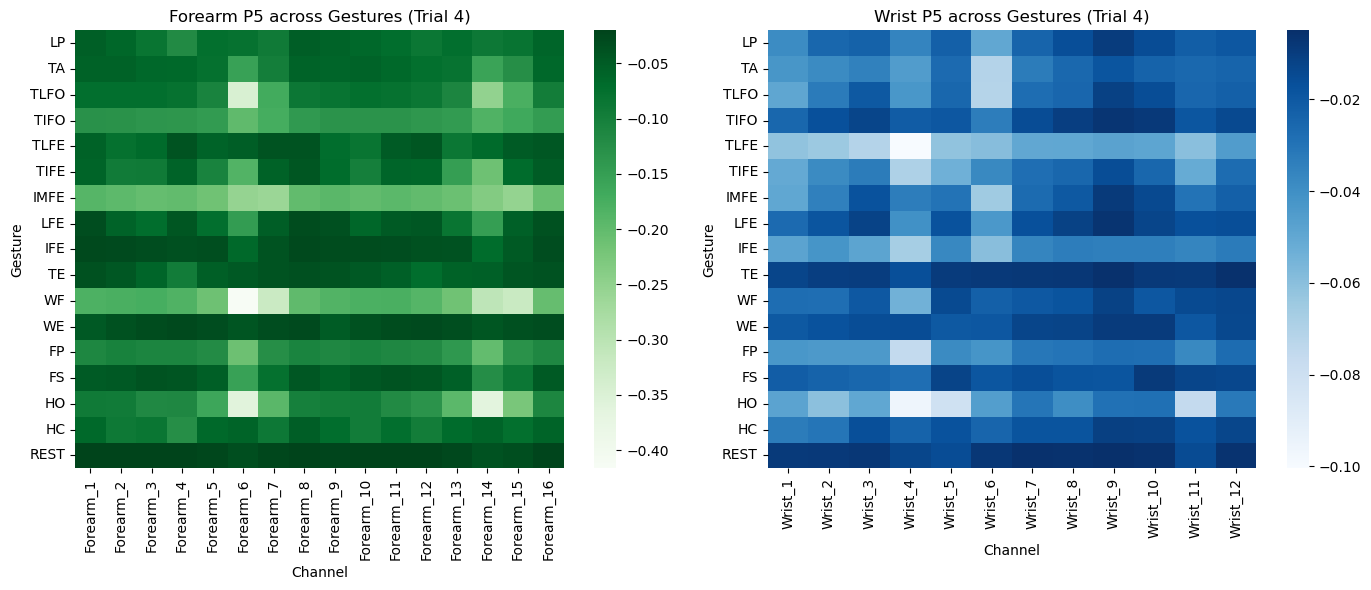

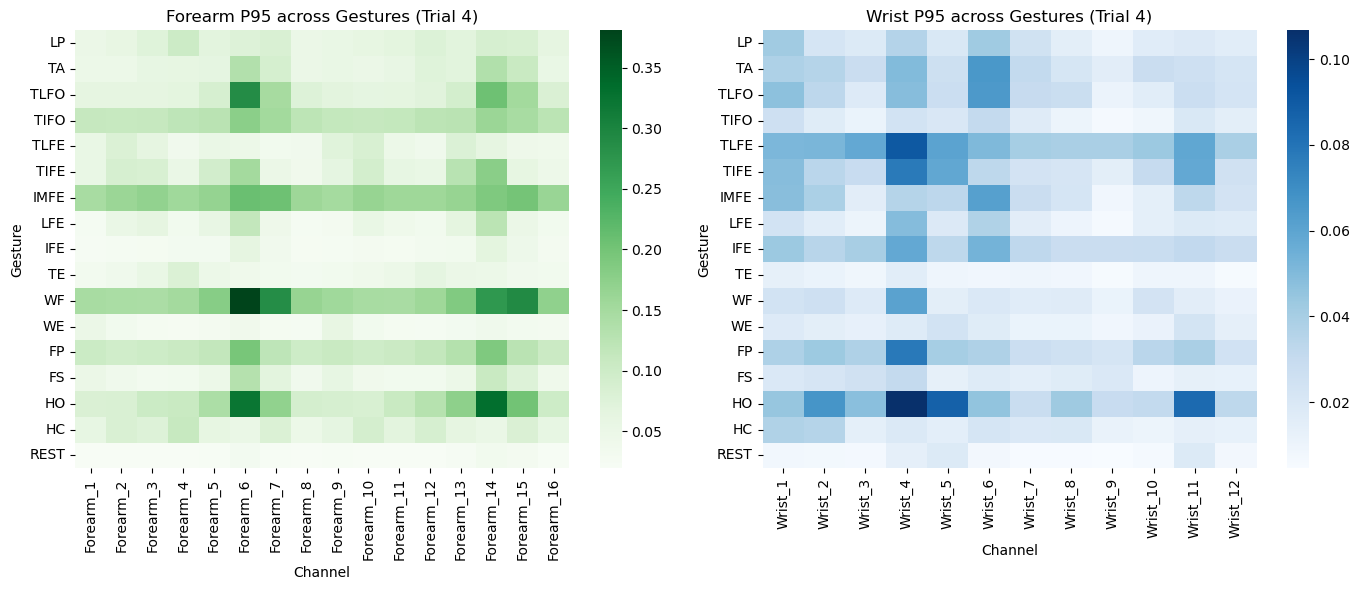

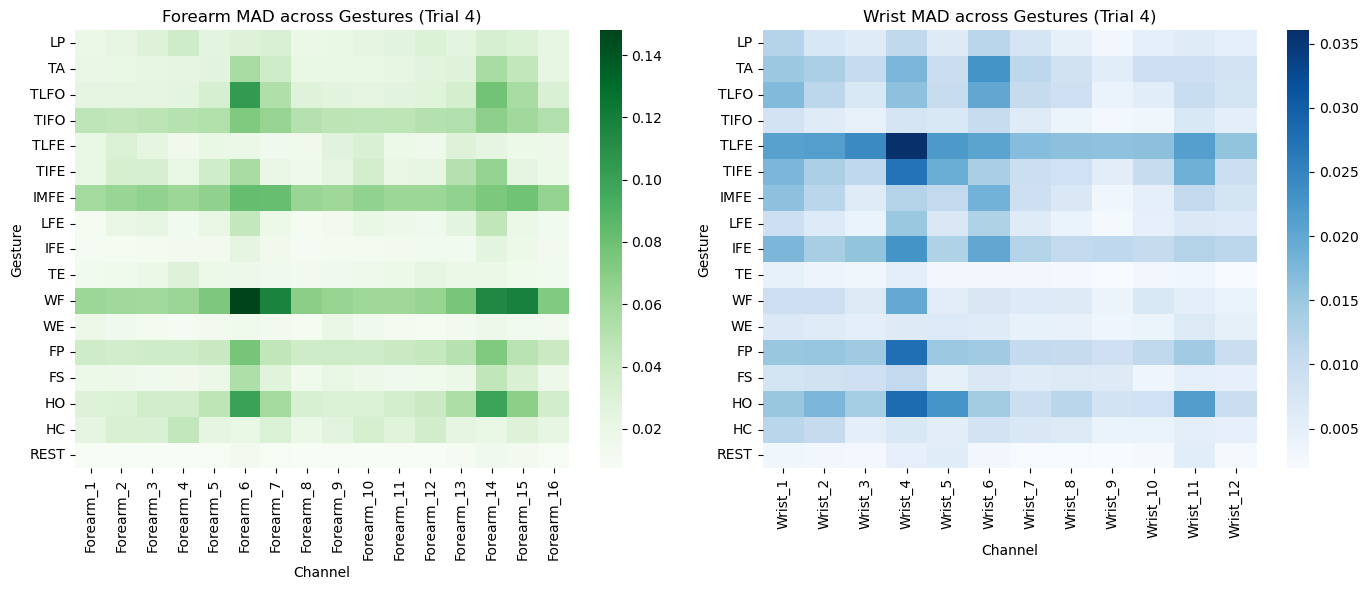

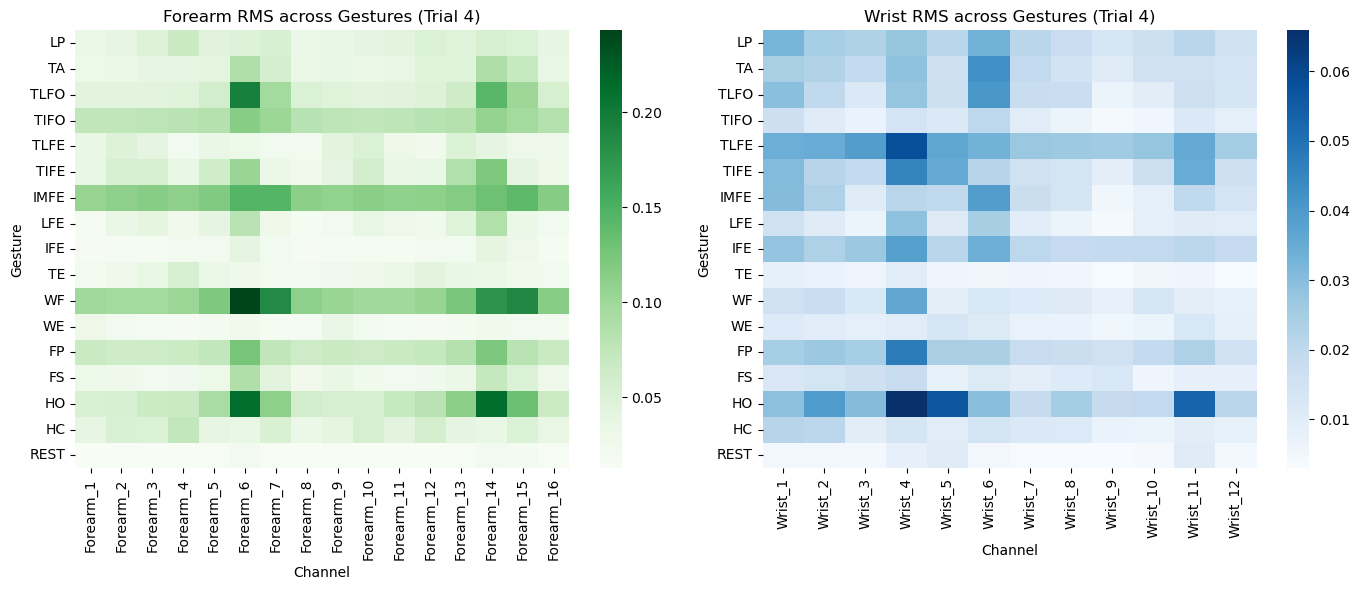

In [6]:
# Heatmap of P5/P95/MAD/RMS across all channels and all gestures for a single trial
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select the trial to compare (use trial_idx from previous cells)
trial_to_compare = trial_idx  # or set to any valid trial index (0-6)

# Prepare metrics for all gestures and all channels
num_gestures = 17
num_forearm = forearm.shape[1]
num_wrist = wrist.shape[1]
metrics_names = ['P5', 'P95', 'MAD', 'RMS']

# Initialize storage for metrics
forearm_metrics_all = []
wrist_metrics_all = []

for g_idx in range(num_gestures):
    # Load data for this gesture and trial
    forearm_g = data['DATA_FOREARM'][trial_to_compare, g_idx]
    wrist_g = data['DATA_WRIST'][trial_to_compare, g_idx]

    # Compute metrics for each channel
    forearm_metrics_g = [calculate_signal_metrics(forearm_g[:, ch]) for ch in range(num_forearm)]
    wrist_metrics_g = [calculate_signal_metrics(wrist_g[:, ch]) for ch in range(num_wrist)]

    forearm_metrics_all.append(forearm_metrics_g)
    wrist_metrics_all.append(wrist_metrics_g)

# Convert to DataFrames for easier plotting
def metrics_to_df(metrics_all, channel_labels, gesture_labels):
    dfs = {}
    for metric in metrics_names:
        arr = np.array([[ch_metrics[metric] for ch_metrics in gesture_metrics] for gesture_metrics in metrics_all])
        df = pd.DataFrame(arr, columns=channel_labels, index=gesture_labels)
        dfs[metric] = df
    return dfs

forearm_labels = [f'Forearm_{i+1}' for i in range(num_forearm)]
wrist_labels = [f'Wrist_{i+1}' for i in range(num_wrist)]

forearm_dfs = metrics_to_df(forearm_metrics_all, forearm_labels, gesture_labels)
wrist_dfs = metrics_to_df(wrist_metrics_all, wrist_labels, gesture_labels)

# Plot heatmaps for each metric
for metric in metrics_names:
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(forearm_dfs[metric], cmap='Greens', annot=False)
    plt.title(f'Forearm {metric} across Gestures (Trial {trial_to_compare+1})')
    plt.xlabel('Channel')
    plt.ylabel('Gesture')

    plt.subplot(1, 2, 2)
    sns.heatmap(wrist_dfs[metric], cmap='Blues', annot=False)
    plt.title(f'Wrist {metric} across Gestures (Trial {trial_to_compare+1})')
    plt.xlabel('Channel')
    plt.ylabel('Gesture')

    plt.tight_layout()
    plt.show()

## 2.3 -  Multiple trials from one gesture